## **Single-cell RNA Sequencing analysis project** 

This notebook is the outcome of a personal challenge I undertook to learn single-cell RNA sequencing (scRNAseq) analysis.

1. For this purpose, I decided to reconstruct a Nature paper (https://www.nature.com/articles/s41586-021-03569-1). 

   The authors in this study investigated lung cells from multiple COVID-19 patients who succumbed to the disease, to construct a comprehensive cellular atlas.

2. As a native Python programmer, I chose to utilize the Scanpy package for the task. 
   While Scanpy may be relatively new and less widespread compared to its R counterpart, Seurat, its community is rapidly expanding. 
   Moreover, Scanpy seamlessly integrates with various Python's multiomics packages, such as Squidpy for spatial transcriptomics.
   Frankly, the most significant advantage of Scanpy - it's in Pyhton =)!

3. I took advantage of this work to raise my visualization skills by making sure to create plots designed similarly as possible to the plots in the article.

This project is an ongoing endeavor, and I welcome any questions, tips, critiques, or suggestions that could help me enhance my skills.

**Yatir.**

June 8, 2023

In [1]:
import os 
import collections
import numpy as np
import scanpy as sc
import pandas as pd 
import seaborn as sns
from scipy import stats
sc.settings.verbosity = 3
from scipy.sparse import csc_matrix
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import ScalarMappable
plt.rcParams['font.size'] = 7
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

- To download the data, I went to the data availiability section of the paper - https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524
- There, I downloaded the tar file - GSE171524_RAW.tar (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524)

In [2]:
resume_work = True
dir = r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\GSE171524_RAW'

**Ribososmal genes**

- Using a set of ribosomal gene names, from the Broad institute.
- This will be in used in the preprocessing step.

In [3]:
ribo_gene_df = pd.read_csv(r'https://www.gsea-msigdb.org/gsea/msigdb/human/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=TSV', sep='\t')
ribo_gene_df = ribo_gene_df[ribo_gene_df.STANDARD_NAME=='GENE_SYMBOLS']
ribo_gene_names = ribo_gene_df.loc[:, 'KEGG_RIBOSOME'].values[0].split(',')

--------------
### **1. Preprocessing**

This step main objective is to distinguish and between cells and debree, and to filter non-cells.

**Hard filtering** :

- ***filter_genes*** - Filter poorley expressed genes by removing genes with respect to their count among the cells. Common values to use as a general rule of thumb, are between 5-10 as a minimum threshold for min_cells.

- ***filter_cells*** - Filter low-quality cells based on the number of expressed genes or the total count of gene expression. Values somehwere between 200-500 genes, are common to be used as the min_genes threshold input to the function. Values alike, ensures that cells with poor RNA quality or low sequencing depth are removed from the dataset.

To digest the right threshold values, one can use the function ***sort_values*** to examine and observe the dataframes.

---
**The preprocessing includes several steps**:

- Reading all the avaliable samples
- Filtering cells comprising less than 300 genes.
- Filtering genes will take place after concatenation.
- Labeling mitochondrials genes, and filtering cells that contains 10 percent or more of them out of the total. 
- Labeling ribosomal genes, and filtering cells that contains 2 percent or more of them out of the total.
- Calculating the .98 quatile of the gene counts per sample, and filtering cells which comprise more gene counts than this value.
- Adding sample identifiers to the data.
- Creating QC matrics for further analyses.

In [4]:
def preprocessing(sample_path):

    adata = sc.read_csv(sample_path)
    adata = adata.T
    adata.X = csc_matrix(adata.X)
    adata.obs['sample'] = os.path.basename(sample_path).split('_')[1]
    sc.pp.filter_cells(adata, min_genes=300)

    adata.var['mito'] = adata.var.index.str.startswith(('MT-', 'mt-', 'Mt-'))
    adata.var['ribo'] = adata.var.index.isin(ribo_gene_names)
    sc.pp.calculate_qc_metrics(adata,
                               expr_type='counts', # default value
                               var_type='genes', # default value
                               qc_vars=['mito', 'ribo'],
                               percent_top=None, 
                               log1p=False, 
                               inplace=True)

    upper_limit = np.quantile(adata.obs.n_genes_by_counts, 0.98)
    adata = adata[adata.obs.n_genes_by_counts < upper_limit, :]
    adata = adata[adata.obs.pct_counts_mito < 10, :]
    adata = adata[adata.obs.pct_counts_ribo < 2, :]
    return adata

if not resume_work:
    adata_list = [preprocessing(os.path.join(dir, sample_file)) for sample_file in os.listdir(dir)]

**Adata in general** : 
- vars are the gene names.
- obs (obsrvation) are the cell barcodes.
- X is a numpy array of the counts which corresonds to the afforementioned variables.

**Columns that were added to the dataframes in the previous cell** : 

**adata.obs** (cells as index) : 
- n_genes_by_counts - the total number of genes that were detected at least once in this cell (also refered as 'positive counts').
- total_counts - the total genes (features) found within this cell.

**adata.vars** (genes [features] as index) : 
- n_cells_by_counts - the number of cells, on which any appearance of this gene (feature) is present.
- mean_counts - devding the total counts of this gene (feature) by the number of all cells.
- pct_dropout_by_counts - the percentage of cells on which this gene (feature) is absent.

This metric can be useful for quality control purposes, as cells with a low number of detected genes may be low-quality or have undergone technical problems during the experimental process. It can also be used to compare the level of transcriptional activity between different cell types or conditions.

---

**Concatenating all the samples together**
- the adata object contains all the concatenated samples.
- Since the pre-processing stage is time consuming, one can use the resume_work binary parameter to use the already combined files and avoid repeating the process.
- samples in the adata, are annotated as control/covid-19 based on the sample identifier which was added previously.
- Filter genes - that are found in less than 10 cells.

In [5]:
if resume_work:
    adata = sc.read_h5ad(os.path.join(dir, 'combined_samples.h5ad'))

else:
    adata = sc.concat(adata_list)
    adata.write_h5ad(os.path.join(dir, 'combined_samples.h5ad'))

adata.obs['covid'] = adata.obs.loc[:, 'sample'].apply(lambda sample:'Covid-19' if 'cov' in sample else 'Control')
sc.pp.filter_genes(adata, min_cells=10)
adata

filtered out 4974 genes that are detected in less than 10 cells


AnnData object with n_obs × n_vars = 108489 × 29572
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'covid'
    var: 'n_cells'

----
**Normalization**

Why?
- Different cell types holds different amount of mRNA (transcripts detected), and rather than absolute values, we wish to examine concentrations.
- Technicalities can cause variation in the data, considering even the same cell types, and with simple normalization steps, we can get rid of this noise.

Two steps are included in the Noramilzation step:
- **Scaling** - Using scanpy's ***normalized_total*** function we manipulate the cell counts so that the total counts of each will be the same value (10000), in a manner which each cell counts, will be evaluated with repsect to its partial values from the total. .
- **Log transformation** - Using scanpy's ***log1p*** func. we manipulate the counts in the X array by $X=log(X+1)$. This transformation has three main benefits. [1] Values of expression that are log-transformed are representatives of log-fold changes, the kind of changes we look for in omics analysis. [2] Though not removed, the relationship between the mean and the variance (or the standard deviation) in the data, is being mitigated due to log transformation. [3] The transformation is remove some of the noise (skewness), and therefore create a better starting point for the downstream analysis, a step that requires normally distributed data.

In [6]:
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 108489 × 29572
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'covid'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'count'

---
**Highly variable genes** - The ***highly_variable_genes*** function is used to identify genes that are highly variable across cells, which are often the most informative genes for downstream analysis later-on. 

These are the cells that are the most importent when it comes to clustering, dimensionality reduction, and differential expression analysis.

after runnig the command, four columns will be added to the **adata.obs** dataframe : 
- highly_variable - a boolean indicator of highly-variable genes
- means - contains the mean expression of each gene across all cells. The difference between these two columns is that means is a normalized measure of gene expression, typically obtained through some form of normalization such as library size normalization, whereas mean_counts is a raw measure of gene expression reflecting the average number of transcripts of each gene detected in each cell.
- dispersions - a measure for the deviation of the gene expression from the expected level based on its mean expression. Genes with high dispersion have more variable expression levels across cells, while genes with low dispersion have more consistent expression levels.
- dispersions_norm - a normalized version of the dispersions values.

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:11)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


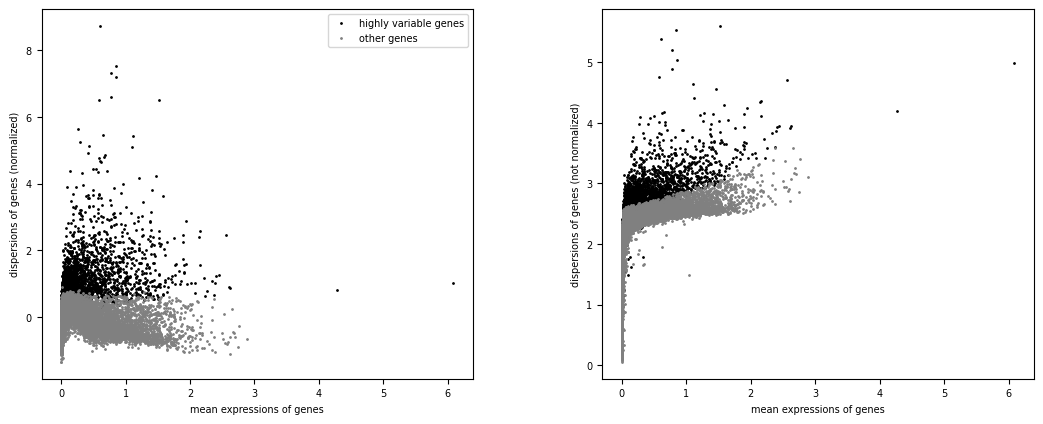

In [7]:
sc.pp.highly_variable_genes(adata, 
                            n_top_genes=3000,
                            flavor='seurat',
                            subset=False, # because I want to examine the filtered in the plot.
                            batch_key='sample')
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

##### **PCA** (Principle component analysis)
- Because thousands of genes are left in our analysis, and due to the fact that genes tend to be co-regulated, we want to group them together when they share expression trends. 
- Scanpy's pca method uses the implementation of scikit-learn. 
- The PCA procedure adds to the AnnData object (adata), an additional parameter which is called - obsm - Observation Matrix.
- adata.obsm['X_pca'] is the represntation of the PCA. Each row represent a cell in the data, and each column represent a PC so that the values in this column are the position of this cell along this specific PC axis.
- Each cell is represented by the PCAs, for which in scanpy the default number is 50.

In [8]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


- Now that PCs were computed, they can be used to calculate a neighbors graph.
- The neighbors function adds to the adata object another parameter which is called obsp - stands for, Observation SParse matrix. 
- This sparse matrix stores information about the pairwise distances or similarities between the cells in the dataset, which is used to construct a graph representing the relationships between the cells. Each cell is represented by a node in the graph, and the edges between nodes indicate the strength of the relationship between the cells they represent.
- adata.obsp['connectivities'] - a sparse pairwise matrix ($cellXcell$) representing the connectivities between the cells
- adata.obsp['distances'] - a sparse pairwise matrix ($cellXcell$) representing the distances between the cells.
- This two matrices will be used to do the clustering.
- Afterwise, we use the umap function to conduct a dimension reduction.
- The umap calculation is being stored in adata.obsm as a matrix - adata.obsm['X_umap']
- Finally I used the The Leiden algorithm to cluster the graph, and it will be in use to identify cell types.

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.99, key_added='leiden') # .99 gives -> 23 clusters 
adata.write(os.path.join(dir, 'integrated_samples.h5ad'))

computing neighbors
    using 'X_pca' with n_pcs = 50


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:23)
running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:33)


----
### **2. Downstream analysis**
**Clusatering cells by their gene expression**
- The previous step managed to divide the cells in the data, into 23 clusters.
- The next figure depicts the sample distribution along the clusters, together with the actuall clusters.
- Examine the plots together, we can see for instance, that cluster 21 exclusively originates from a single sample.

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


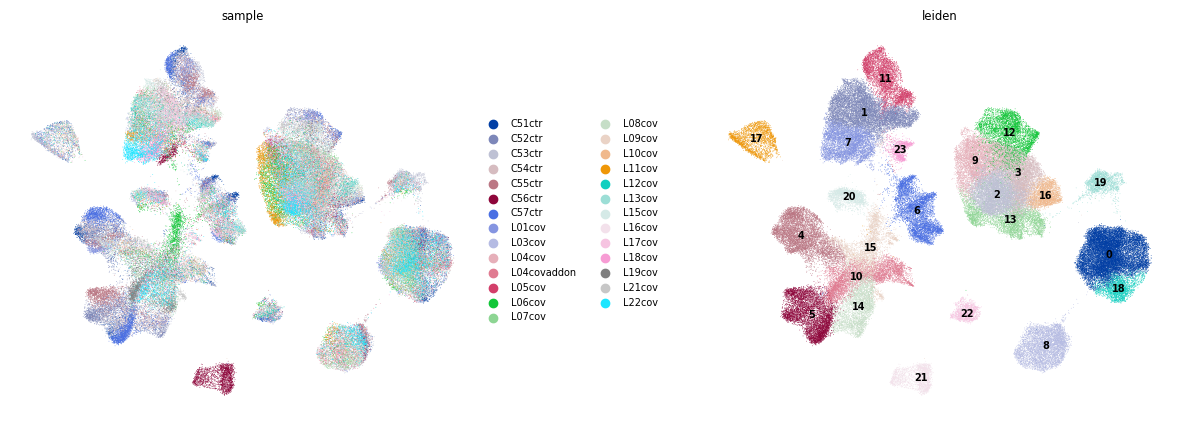

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plt.subplots_adjust(wspace=.5)
sc.pl.umap(adata, color=['sample'], frameon=False, ax=ax1, show=False)
sc.pl.umap(adata, color=['leiden'], frameon=False, legend_loc='on data', ax=ax2, show=False)
plt.show()

---
**Marker identification** :

- In Scanpy, the equivalent function to Seurat's FindAllMarkers is sc.tl.rank_genes_groups(). 
- This function performs differential gene expression analysis on the adata object and returns a table of genes ranked by their statistical significance in distinguishing between groups of cells.

So, sc.tl.rank_genes_groups() to perform differential gene expression analysis, specifying the groupby argument to group the cells by their cell_type annotation. Finally, we use sc.get.rank_genes_groups_df() to retrieve the results as a Pandas dataframe.

In [11]:
sc.settings.verbosity=2
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
markers = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=.05, log2fc_min=.25)

ranking genes
    finished (0:09:00)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\tools\_ran

----
##### **Cluster annotation (cell type labeling)**:
**Sources**:
- https://panglaodb.se/index.html
- https://www.cellsignal.com/pathways/immune-cell-markers-mouse
- Data from CellMarker that was introdcued here as mrkrs_df (lung_mrkrs)
- https://www.nature.com/articles/s41586-020-2922-4

**Notes**:
- Even though there are several ML-based tools (for Python and R) for automatic cell labeling, I decided to - Learn this step the hard way, and to perform a manual labeling.
- This way, is considered by many the most precise way (if it is done write), and it is an iterative and painstaking step. 
- This step combined several sources of cell type markers, and many scrolls along this notebook.
- The next four cells are represntatives of the making of this step that I have retained as an example. 
- The last one, is a python dictionary maintaining the actuall lebeling.



In [12]:
human_cell_mrkrs = pd.read_excel(r'C:/Users/DuduB21/OneDrive/code/single_cell_analysis/Cell_marker_Human.xlsx') # CellMarker
lung_mrkrs = human_cell_mrkrs[human_cell_mrkrs.tissue_type=='Lung']
lung_mrkrs = lung_mrkrs.drop(columns=['species', 'tissue_class', 'cell_type', 'cancer_type', 'journal', 'year', 'Title'])

In [13]:
def gene_markers(human_cell_mrkrs): # was in used in the making...
    markers_prevalence = dict(collections.OrderedDict(sorted(markers_prevalence.items(), 
                                                             key=lambda x: x[1], 
                                                             reverse=True)))
    return markers_prevalence

mrkrs_df = lung_mrkrs[lung_mrkrs.cell_name.str.contains('neu')]

**Adding the labeling to adata dataframes**

In [53]:
# for .99 resolution :
cluster_cell_types = \
                   {0:'T cells', # 'PTPRC' (CD45) which is marker for Immune cells in generarl -> 'CD3E' which is marker for T cells -> 'CD4' for CD4+ (upper part) / 'CD8A' cd8+ (lowerpart) - could be seperated later.
                    1:'LipF/\nAdvF',
                    2:'Macrophages', # ['CD68', 'MARCO', 'APOE'
                    3:'Macrophages', # ['CD14']
                    4:'AT1', # 'AGER']
                    5:'AT2', # SFTPC
                    6:'Endothelial\ncells', # ['PECAM1', 'VWF']
                    7:'MyoF/\nFibM',
                    8:'Plasma\ncells', # ['MZB1', 'JCHAIN','IGHG1', 'XBP1','leiden']
                    9:'Macrophages', # ['CD14']
                    10:'10', # SFTPC
                    11:'AlvF', # ['GPC3']
                    12:'Macrophages', # ['IKZF2'] maybe Alveolar macrophage
                    13:'Monocytes/DCs', # ['ZBTB46']
                    14:'AT2', # SFTPC 
                    15:'15', # SFTPC
                    16:'Macrophages', # ['CD4']
                    17:'Epithelial\ncells', # ['EPCAM']
                    18:'NK', 
                    19:'B\ncells', # ['PXK', 'CD19']
                    20:'Alveolar\ngoblet',
                    21:'Epithelial\ncells', # ['TAGLN', 'ACTA2']
                    22:'Mast', # ['KIT', 'TPSB2']
                    23:'ASM'} # ['MYH11', 'CNN1', 'ACTG2']

cluster_cell_types = {str(k):v for k,v in cluster_cell_types.items()}
adata.obs['cell_type_rep'] = adata.obs.leiden.map(cluster_cell_types)
adata.obs['cell_type'] = adata.obs.leiden.map({k:v.replace('/\n', '_').replace('\n',' ').replace('/','_') for k, v 
                                                                                        in cluster_cell_types.items()})
adata.write(os.path.join(dir, 'integrated_samples_annotated.h5ad'))

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


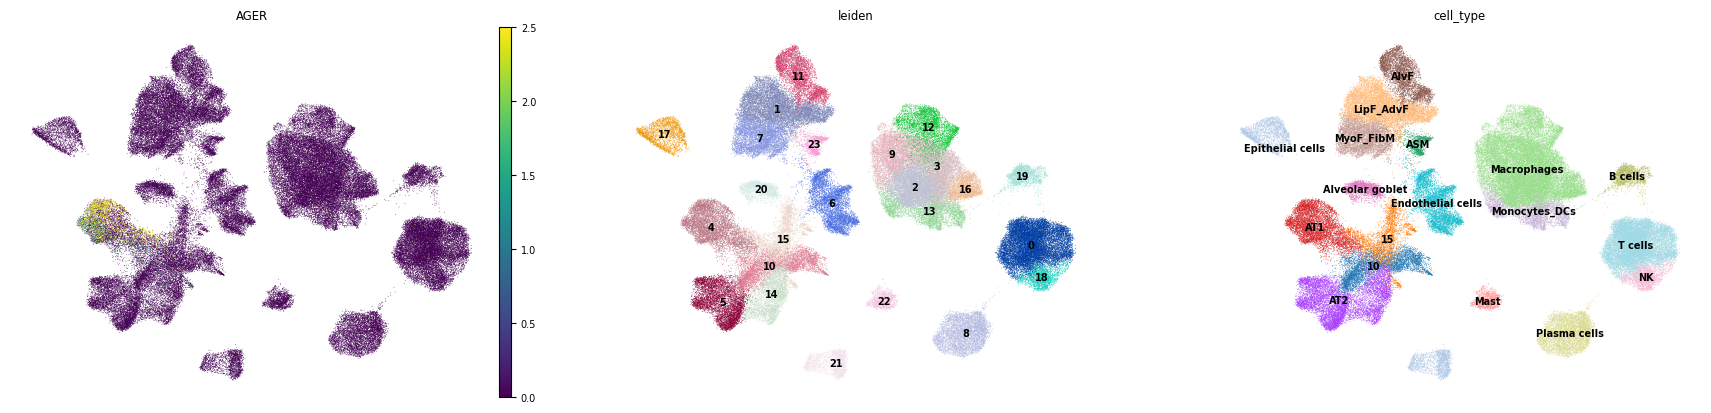

In [15]:
sc.pl.umap(adata, color=['AGER', 'leiden', 'cell_type'] , frameon=False, legend_loc='on data', vmax=2.5)

---
**Cell type frequencies dataframe making**

In [54]:
count_per_sample_dic = dict(collections.Counter(adata.obs.loc[:, 'sample']))
counts_per_CT_df = adata.obs.groupby(['sample', 'covid', 'cell_type']).count().reset_index().loc[:, ['sample', 
                                                                                                     'covid', 
                                                                                                     'cell_type', 
                                                                                                     'total_counts']]
counts_per_CT_df = counts_per_CT_df[counts_per_CT_df.total_counts > 0]
counts_per_CT_df.rename({'total_counts':'cell_count'}, inplace=True, axis=1)
counts_per_CT_df['sample_cell_count'] = counts_per_CT_df.loc[:, 
                                                'sample'].apply(lambda sample:count_per_sample_dic.get(sample))
counts_per_CT_df['sample_cell_count'] = counts_per_CT_df.sample_cell_count.astype(int)
counts_per_CT_df['freq'] = counts_per_CT_df.cell_count/counts_per_CT_df.sample_cell_count

major_diff_dict = \
                   {'B cells':'B/plasma',
                    'Plasma cells':'B/plasma',
                    'LipF_AdvF':'Fibroblasts',
                    'MyoF_FibM':'Fibroblasts',
                    'T cells':'T/NK',
                    'NK':'T/NK',
                    'Macrophages':'Myeloid',
                    'Endothelial cells':'Endothelium',
                    'Epithelial cells':'Epithelia',
                    'AT1':'Epithelia',
                    'AT2':'Epithelia',
                    'Mast':'Mast cells'}

counts_per_CT_df['mjr_dfrntion_cell_type'] = counts_per_CT_df.cell_type.map(major_diff_dict)
counts_per_CT_df = counts_per_CT_df[~(counts_per_CT_df.mjr_dfrntion_cell_type.isna())]
counts_per_CT_df

,sample,covid,cell_type,cell_count,sample_cell_count,freq,mjr_dfrntion_cell_type
3,C51ctr,Control,AT1,822,5948,0.138198,Epithelia
4,C51ctr,Control,AT2,739,5948,0.124243,Epithelia
7,C51ctr,Control,B cells,42,5948,0.007061,B/plasma
8,C51ctr,Control,Endothelial cells,608,5948,0.102219,Endothelium
9,C51ctr,Control,Epithelial cells,268,5948,0.045057,Epithelia
...,...,...,...,...,...,...,...
966,L22cov,Covid-19,Mast,7,6370,0.001099,Mast cells
968,L22cov,Covid-19,MyoF_FibM,1274,6370,0.200000,Fibroblasts
969,L22cov,Covid-19,NK,121,6370,0.018995,T/NK
970,L22cov,Covid-19,Plasma cells,532,6370,0.083516,B/plasma


---
**general functions for plotting**

In [32]:
def umap_plot_foramt(ax):
    ax.set_title(str())
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)

def color_pallet():
    return {'Control':'#006D81', 
            'Covid-19':'#A90639', 
            'AT1':'#0072B2', 
            'AT2':'#0AB45A',
            'KRT8':'#F84D7B',
            'CLDN4':'#F84D7B',
            'CDKN1A':'#F84D7B',
            'DATP':'#F84D7B'}

def seurat_heatmap_colorbar():
    colors = [(183/255, 0, 235/255), (0, 0, 0), (1, 1, 0)]
    # Define the positions for the colors in the color map
    positions = [0, 0.5, 1]
    # Create the custom color map
    cmap = LinearSegmentedColormap.from_list('seurat_heatmap', list(zip(positions, colors)))
    return cmap

def boxplot_properties(clr, lnw=.85):
    boxprops = dict(linewidth=lnw, edgecolor=clr, facecolor='white')
    medianprops = dict(linewidth=lnw, color=clr)
    whiskerprops = dict(linewidth=lnw, color=clr)
    return boxprops, medianprops, whiskerprops

def format_pvalue(pvalue, thresold=.01):
    if pvalue > thresold:
        pvalue = np.format_float_positional(pvalue, precision=3)
    else:
        pvalue = np.format_float_scientific(pvalue, precision=1, exp_digits=2)
    return pvalue

---
**Major cell type figures**

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


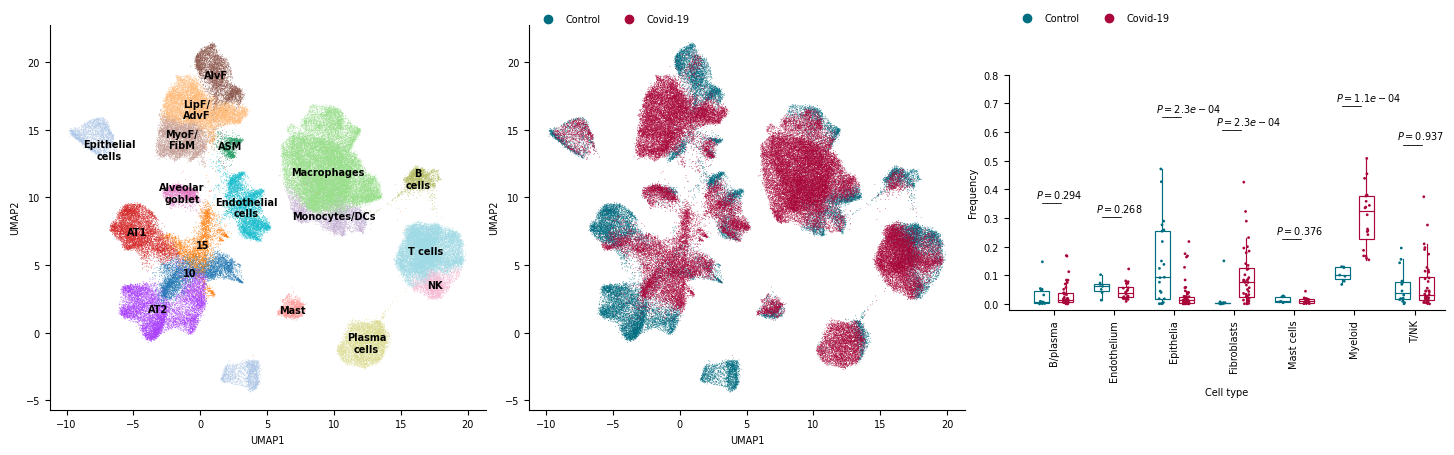

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.1)
left, bottom, width, height = ax3.get_position().bounds
ax3.set_position([left, bottom+.2, width, height-.3])

# adding the umpas :
sc.pl.umap(adata, color=['cell_type_rep'], frameon=True, 
           legend_loc='on data', show=False, ax=ax1)

sc.pl.umap(adata, color=['covid'], frameon=True, 
           legend_loc='right margin', palette={'Covid-19':'#A90639', 'Control':'#006D81'}, show=False, ax=ax2)

# boxplot : 
grouped = counts_per_CT_df.groupby('mjr_dfrntion_cell_type')
cell_types = [group[0] for group in grouped]
controls = [sub_df[sub_df.covid=='Control'].freq for _, sub_df in grouped]
covid = [sub_df[sub_df.covid=='Covid-19'].freq for _, sub_df in grouped]
offset=.2
positions = [(pos - offset, pos + offset) for pos in range(0, len(cell_types))]
ticks_positions = [pos for pos in range(0, len(cell_types))]

pvalues_dict = dict()
for CT, ctrl, cvd in zip(cell_types, controls, covid):
    pvalue = stats.ranksums(ctrl, cvd).pvalue
    pvalue = format_pvalue(pvalue)
    max_values = max(np.concatenate((cvd.to_numpy(), ctrl.to_numpy())))
    pvalues_dict[CT] = (pvalue, max_values)

widths=.25
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Control'))
ax3.boxplot(labels=cell_types, 
            x=controls, 
            positions=[pos[0] for pos in positions], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Covid-19'))
ax3.boxplot(labels=cell_types, 
            x=covid, 
            positions=[pos[1] for pos in positions], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

for (CT, pvalue_max), loc in zip(pvalues_dict.items(), positions):
    ax3.text(x=loc[0]-.1, 
             y=np.clip(a=pvalue_max[1]+.2, a_min=0, a_max=.8), 
             s=f'$P = {pvalue_max[0]}$')
    ax3.text(x=loc[0]-.1, 
             y=np.clip(a=pvalue_max[1]+.2, a_min=0, a_max=.8)-0.005, 
             s='  ____')

ax3.set_xticks(ticks_positions, cell_types, rotation=90)

sns.stripplot(data=counts_per_CT_df,
              x='mjr_dfrntion_cell_type', 
              y='freq', 
              hue='covid', 
              order=cell_types,
              size=2, 
              palette=color_pallet(),
              linewidth=0, 
              dodge=True,
              legend=False,
              ax=ax3,
              jitter=True,
              native_scale=True)

for ax in [ax1, ax2, ax3]:
    ax.set_title(str())
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    if ax in [ax1, ax2]:
        ax.set_xticks(np.arange(-10, 25, 5))
        ax.set_yticks(np.arange(-5, 21, 5))

for ax, loc in zip([ax2, ax3], [(0, 1.05), (0, 1.3)]):
    ax.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                        Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
               loc='upper left', frameon=False, ncols=2, bbox_to_anchor=loc)

ax3.set_ylim(-.02,.8)
ax3.set_xlim(-.75,6.5)
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Cell type')

fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'fig1_b_c_d.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

---
**AT analysis**

In [34]:
AT_adata = adata[adata.obs.cell_type.isin(['AT1', 'AT2'])].copy()
sc.tl.leiden(AT_adata, resolution=.65, key_added='leiden_AT') # -> leading to 9 clusters 
sc.tl.umap(AT_adata, n_components=3)
AT_umap = AT_adata.obsm['X_umap']

DATP_sig_path = r'https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03569-1/MediaObjects/41586_2021_3569_MOESM11_ESM.xlsx'
DATP_sig = pd.read_excel(DATP_sig_path, sheet_name='our_datp_sig').iloc[2:,0].to_list()

sc.tl.score_genes(AT_adata, 
                  gene_list=DATP_sig, 
                  ctrl_size=163, 
                  n_bins=50, 
                  score_name='DATP')

DATP_sig_threshold = 0.4
AT_adata.obs['isDATP'] = AT_adata.obs.loc[:, 
                ['cell_type', 'DATP']].apply(lambda x: 'DATP' if x.DATP > DATP_sig_threshold else x.cell_type, axis=1)

DATP_ratio = AT_adata.obs.copy()
DATP_ratio['isDATP'] = DATP_ratio.isDATP.apply(lambda x:'DATP' if x=='DATP' else 'AT')
DATP_ratio = DATP_ratio.groupby(['sample', 'covid', 'isDATP']).count().reset_index().loc[:, ['sample', 
                                                                                             'isDATP', 
                                                                                             'total_counts']]
DATP_ratio = DATP_ratio[DATP_ratio.total_counts > 0]
DATP_ratio.rename({'total_counts':'cell_count'}, inplace=True, axis=1)
DATP_ratio = DATP_ratio.pivot(index='sample', columns='isDATP', values='cell_count').reset_index()
DATP_ratio['freq'] = DATP_ratio['DATP'] / DATP_ratio['AT']
DATP_ratio['sample'] = DATP_ratio.loc[:, 'sample'].apply(lambda x:'Control' if 'ctr' in x else 'Covid-19')
DATP_ratio = DATP_ratio.loc[:,['sample', 'freq']]
DATP_ratio.rename({'sample':'covid'}, inplace=True, axis=1)
DATP_ratio = DATP_ratio[DATP_ratio.freq < 1]

running Leiden clustering
    finished (0:00:01)
computing UMAP
    finished (0:00:08)
computing score 'DATP'
    finished (0:00:00)


c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


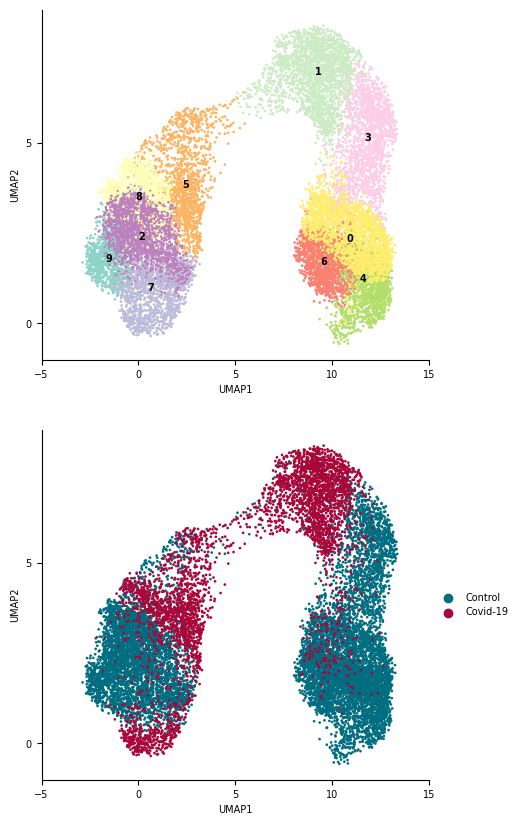

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,10))
sc.pl.umap(AT_adata, color=['leiden_AT'], legend_loc='on data', 
           frameon=True, s=15, alpha=1, show=False, ax=ax1, palette='Set3_r')

sc.pl.umap(AT_adata, color=['covid'], legend_loc='right margin', 
           frameon=True, s=15, alpha=1, show=False, ax=ax2)

umap_plot_foramt(ax1)
umap_plot_foramt(ax2)
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(-5, 20, 5))
    ax.set_yticks(np.arange(0, 10, 5))

fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'fig3_a_b.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


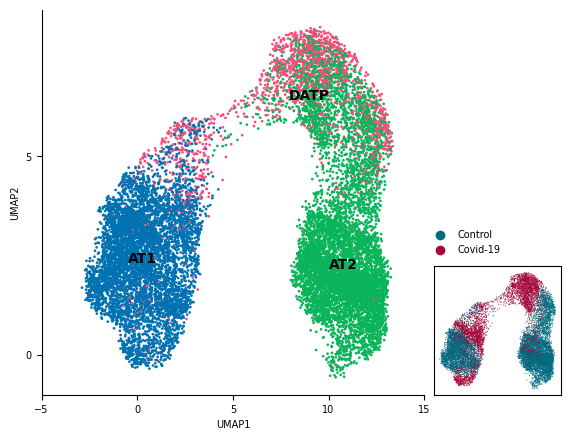

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplots_adjust(wspace=0.025)
left2, bottom2, width2, height2 = ax2.get_position().bounds
ax2.set_position([left2, bottom2, width2/3, height2/3])

sc.pl.umap(AT_adata, 
           frameon=True, 
           legend_loc='on data', 
           show=False, 
           ax=ax1, 
           color=['isDATP'], 
           palette=color_pallet(),
           s=15, 
           alpha=1,
           legend_fontweight='semibold', 
           legend_fontsize=10)

sc.pl.umap(AT_adata, 
           frameon=True, 
           show=False, 
           ax=ax2,
           color=['covid'], 
           palette=color_pallet(), 
           size=2)

for ax in [ax1, ax2]:
    ax.set_title(str())

for side in ['right', 'top']:
    ax1.spines[side].set_visible(False)

ax2.set(xlabel=None, ylabel=None)
ax2.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                    Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
           loc='upper center', frameon=False, ncols=1, bbox_to_anchor=(.25, 1.35, 0, 0))

ax1.set_xticks(np.arange(-5, 20, 5))
ax1.set_yticks(np.arange(0, 10, 5))

fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'fig3_f.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

C:\Users\DuduB21\AppData\Local\Temp\ipykernel_18848\195172871.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(sm,


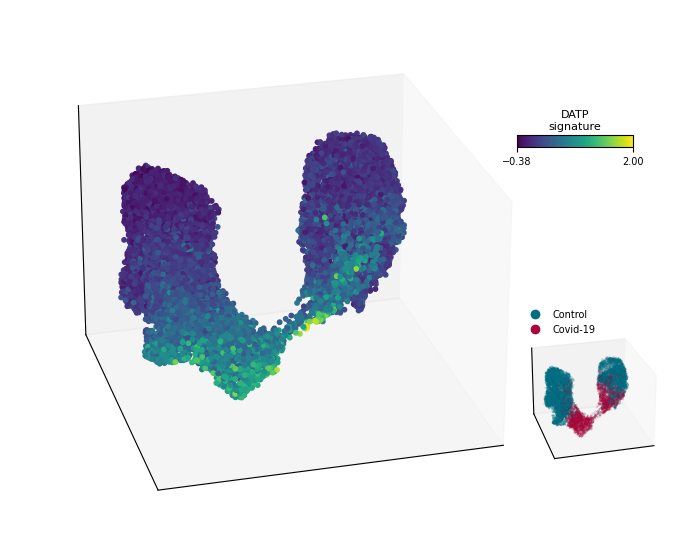

In [37]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax2 = fig.add_subplot(2, 3, 6, projection='3d')

plt.subplots_adjust(wspace=1)

sm = ScalarMappable(cmap='viridis', 
                    norm=mpl.colors.Normalize(vmin=-.38, vmax=2))
sm.set_array(AT_adata.obs.DATP)

ax1.scatter(xs=AT_umap[:,0], 
            ys=AT_umap[:,1], 
            zs=AT_umap[:,2],
            c=AT_adata.obs.DATP,
            # c=AT_adata.obs.isDATP.map(color_pallet()),
            cmap='viridis',
            s=10,
            alpha=1)

cb = plt.colorbar(sm, 
                  orientation='horizontal', 
                  aspect=10,
                  shrink=.75, 
                  anchor=(.125,16),
                  ticks=[-0.38, 2])

cb.ax.xaxis.set_label_position('top')
cb.set_label('DATP\nsignature', fontdict={'size': '8'})

ax2.scatter(xs=AT_umap[:,0], 
            ys=AT_umap[:,1], 
            zs=AT_umap[:,2],
            c=AT_adata.obs.covid.map(color_pallet()),
            s=1e-2,
            alpha=1)

for ax in [ax1, ax2]:
    ax.set_title(str())

for side in ['right', 'top']:
    ax1.spines[side].set_visible(False)

ax2.set(xlabel=None, ylabel=None)
ax2.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
           loc='upper center', frameon=False, ncols=1, bbox_to_anchor=(.3125, 1.125, 0, 0))

ax1.set_xticks(np.arange(-4, 0, 5))
ax1.set_yticks(np.arange(0, 11, 5))

for side in ['right', 'top', 'left', 'bottom']:
    ax2.spines[side].set_visible(False)

for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks(list())
    ax.set_yticks(list())
    ax.set_zticks(list())
    ax.view_init(elev=25, 
              azim=75,
              roll=0)
fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'fig3_h.png'),
            dpi=300, bbox_inches='tight')
plt.show()

In [38]:
def create_violin(adata, 
                  ax, 
                  keys,
                  value_type,
                  grpby='covid',
                  pvalue=True,
                  pvalue_undrln=True,
                  xlabel=None,
                  ylabel=None,
                  linewidth=0.75):
    
    sc.pl.violin(adata, 
             keys=keys, 
             groupby=grpby, 
             show=False, 
             multi_panel=True,
             ax=ax, 
             stripplot=False, 
             log=False,
             xlabel=xlabel,
             ylabel=ylabel,
             linewidth=linewidth)
    
    if len(adata.obs.groupby(grpby))==2 and pvalue:
        groupby_options = list(set(adata.obs.loc[:, grpby]))

        try:
            if value_type == 'obs_col':
                pvalue=stats.ranksums(adata[adata.obs.covid==groupby_options[0]].obs.loc[:, keys],
                                    adata[adata.obs.covid==groupby_options[1]].obs.loc[:, keys])
            elif value_type == 'gene':
                x_array_idx = np.where(adata.var_names==keys)[0][0]
                pvalue=stats.ranksums(adata[adata.obs.covid==groupby_options[0]].X[:,x_array_idx].toarray(),
                                    adata[adata.obs.covid==groupby_options[1]].X[:,x_array_idx].toarray())    
                
            pvalue=pvalue.pvalue
            pvalue = format_pvalue(pvalue)

        except IndexError:
            pvalue=None
            
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks(list())
    
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
        ax.spines[side].set_visible(False)
    
    return ax, pvalue

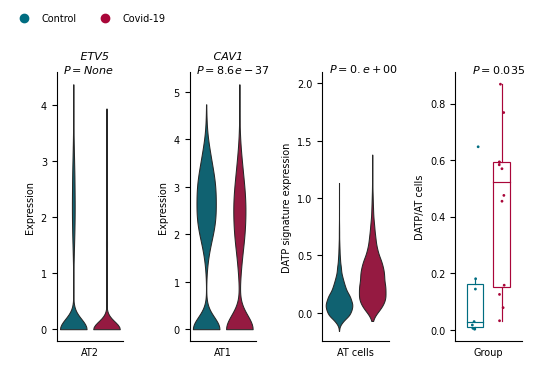

In [39]:
DATP_AT_adata = AT_adata.copy()

fig, DATP_ax = plt.subplots(nrows=1, ncols=4, figsize=(6,3.5))
plt.subplots_adjust(wspace=1)

DATP_ax[0], pvl0 = create_violin(adata=AT_adata[AT_adata.obs.cell_type=='AT2'],
                        ax=DATP_ax[0],
                        keys='ETV5',
                        xlabel='AT2',
                        ylabel='Expression',
                        value_type='gene')

DATP_ax[1], pvl1 = create_violin(adata=AT_adata[AT_adata.obs.cell_type=='AT1'],
                        ax=DATP_ax[1],
                        keys='CAV1',
                        xlabel='AT1',
                        ylabel='Expression',
                        pvalue=True,
                        value_type='gene')

DATP_ax[2], pvl2 = create_violin(adata=AT_adata,
                        ax=DATP_ax[2],
                        keys='DATP',
                        xlabel='AT cells',
                        ylabel='DATP signature expression',
                        pvalue=True,
                        value_type='obs_col')

DATP_ax[2].set_ylim(-.25,2.1)

##########################################

grouped = DATP_ratio.groupby('covid')
widths=.25
controls = grouped.get_group('Control').freq
covids = grouped.get_group('Covid-19').freq
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Control'))
DATP_ax[3].boxplot(x=controls, 
            positions=[0.8], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)
boxprops, medianprops, whiskerprops = boxplot_properties(color_pallet().get('Covid-19'))
DATP_ax[3].boxplot(x=covids, 
            positions=[1.2], 
            widths=widths, 
            patch_artist=True, 
            showcaps=False, 
            showfliers=False, 
            boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops)

umap_plot_foramt(DATP_ax[3])

DATP_ax[3].set_xticks(list())
DATP_ax[3].xaxis.set_tick_params(labelbottom=False)
DATP_ax[3].set_xlabel('Group')
DATP_ax[3].set_ylabel('DATP/AT cells')
DATP_ax[3].set_xlim(.5,1.5)

sns.stripplot(data=DATP_ratio,
              x=[1 for i in range(len(DATP_ratio))], 
              y='freq', 
              hue='covid',
              size=2, 
              palette=color_pallet(),
              linewidth=0, 
              dodge=True,
              legend=False,
              jitter=True,
              ax=DATP_ax[3],
              native_scale=True)

pvl3 = format_pvalue(stats.ranksums(controls, covids).pvalue)

##########################################
    
for ax, pvalue, headline, loc in zip(DATP_ax, 
                                    [pvl0, pvl1, pvl2, pvl3], 
                                    ['ETV5', 'CAV1', '', ''], 
                                    [(-.3,4.57), (-.3,5.4), (-.3,2.1), (0.75,.9075)]):
    ax.text(x=loc[0], 
             y=loc[1], 
             s=f"     {headline}\n$P = {pvalue}$",
             fontdict=dict(fontsize=8, fontstyle='italic'))
    
plt.legend(handles=[Line2D([0], [0], marker='o', color='#006D81', label='Control', linewidth=0),
                        Line2D([0], [0], marker='o', color='#A90639', label='Covid-19', linewidth=0)], 
               loc='center', frameon=False, ncols=2, bbox_to_anchor=(-5.5, 1.2))

fig.savefig(os.path.join(r'C:\Users\DuduB21\OneDrive\code\single_cell_analysis\restore_figures', 'fig3_d_e_g_i.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

c:\Users\DuduB21\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


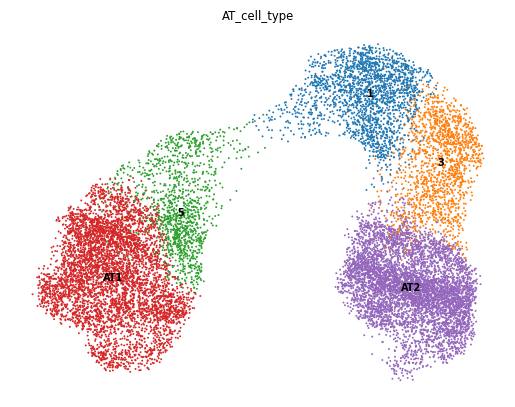

In [40]:
AT_cell_cell_types =    {
                        0:'AT2',
                        1:1,
                        2:'AT1',
                        3:3, 
                        4:'AT2',
                        5:5,
                        6:'AT2',
                        7:'AT1',
                        8:'AT1',
                        9:'AT1'
                        }
AT_adata.obs['AT_cell_type'] = AT_adata.obs.leiden_AT.map({str(k):str(v) for k, v in AT_cell_cell_types.items()})
AT_adata.obs
sc.pl.umap(AT_adata, color=['AT_cell_type'], legend_loc='on data', frameon=False)
# sc.pl.umap(AT_adata, color=['leiden_AT'], legend_loc='on data', frameon=False)

In [41]:
sc.tl.rank_genes_groups(AT_adata, groupby='AT_cell_type', method='wilcoxon')
AT_markers = sc.get.rank_genes_groups_df(AT_adata, group=['AT1', 'AT2'], pval_cutoff=0.05, log2fc_min=0.25)

ranking genes
    finished (0:00:24)


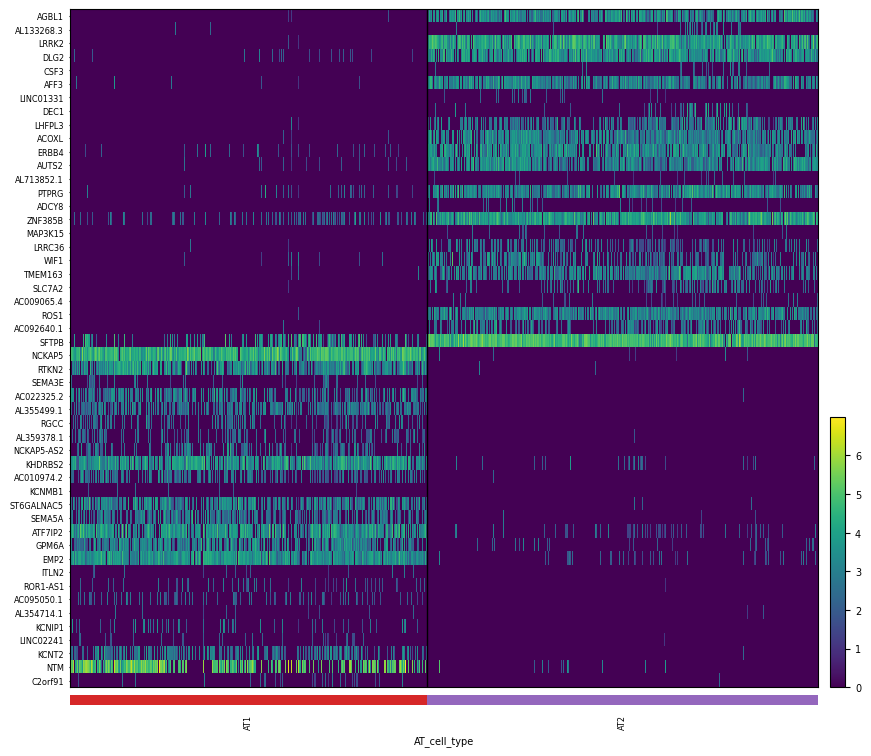

In [42]:
AT_markers.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False], inplace=True)
AT_DEG_lst = AT_markers[AT_markers.group=='AT2'].names.to_list()[:25:] + \
             AT_markers[AT_markers.group=='AT1'].names.to_list()[:25:]

sc.pl.heatmap(AT_adata[AT_adata.obs.AT_cell_type.isin(['AT1', 'AT2'])],
              var_names=AT_DEG_lst, 
              groupby='AT_cell_type',
              swap_axes=True,
              show_gene_labels=True,
              show=True)
plt.show()